# 2D Gaussian Test
The purpose of this notebook is to explore our analysis using a double Gaussian as a test bed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import corner
from scipy.optimize import curve_fit
%matplotlib inline

# Create the 2D Gaussian
Let's do an x0 mean of 1 +/- .25 and x1 mean of 2 +/- 0.5

In [2]:
def Gauss_prob(values,mean,sigma):
    '''
    Calculates Gaussain probability at each data point
    
    Arguments:
        values: The data values of interest
        mean: The mean of the Gaussian
        sigma: The sigma of the Gaussian
    Returns:
       A numpy array of probabilities, one for each value.
    '''
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((values-mean)/sigma)**2)

def dbl_Gauss(data,x0,x1,x0_sig,x1_sig):
    '''
    Calculates Gaussain probability at each data point for a double Gaussian
    
    Arguments:
        data: The x data
        x0: The mean of Gaussian 0
        x1: The mean of Gaussian 1
        x0_sig: The sigma of Gaussian 0
        x1_sig: The sigma of Gaussian 1
    Returns:
       A numpy array of probabilities, one for each x data point.
    '''
    y = (1/(x0_sig*np.sqrt(2*np.pi)) * np.exp(-1/2*((data-x0)**2/(x0_sig**2)))) +(
        1/(x1_sig*np.sqrt(2*np.pi)) * np.exp(-1/2*((data-x1)**2/(x1_sig**2))))
    return y

def get_chisq(xdata,y_noise,yerr_arr,param):
    yfit = dbl_Gauss(xdata,*param)

    chisq = np.sum(((y_noise - yfit)/yerr_arr)**2)
    return chisq
def get_mean_std(values,chisq):
    '''
    Calculates mean and standard deviation by calculating the expectation value of the mean and variance.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each data value
    Returns:
       The mean and standard deviation
    '''
    lh = np.exp(-chisq/2) #Likelihood
    lh_mean = np.sum(values*lh)
    norm = np.sum(lh)
    mean = lh_mean/norm
    lh_std = np.sum((values-mean)**2*lh)
    std = np.sqrt(lh_std/norm)
    return(mean,std)
def get_mean_std_prior(values,chisq,prior_val,prior_mean,prior_std):
    '''
    Calculates mean and standard deviation by calculating the expectation value of the mean and variance.
    It includes a Gaussian prior.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each data value
        prior_val: The values array for the X_i to be used for the Gaussian prior
        prior_mean: The Gaussian Prior on the mean (X_0)
        prior_std: The Gaussian Prior Standard Deviation Sigma_X.
    Returns:
        The mean and standard deviation
    '''
    #Likliehood and Gaussian Prior
    lh_prior = np.exp(-chisq/2)*np.exp(-0.5*((prior_val-prior_mean)**2)/prior_std**2) 
    lh_prior_mean = np.sum(values*lh_prior)
    norm = np.sum(lh_prior)
    mean = lh_prior_mean/norm
    lh_prior_std = np.sum((values-mean)**2*lh_prior)
    std = np.sqrt(lh_prior_std/norm)
    return(mean,std)
def get_posterior(values,chisq,num_bins):
    '''
    Calculates the posterior probability distribution as a function of the values and chi-squared.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each values value
        numbins: The bining you want to use. I generally default to the number of grid points.
    Returns:
       Tuple (prob_arr,bin_center)
       prob_arr: The probability array
       bin_center: The center of each bin the probability array represents
    '''
    #I assume equal space gridding
    hist,bin_edges = np.histogram(values,num_bins)
    prob_idx = np.digitize(values,bin_edges)
    lh_prob = np.exp(-chisq/2)
    norm = np.sum(lh_prob)
    lh_prob = lh_prob/norm
    prob = list()
    for i in range(len(hist)):
        prob.append(np.sum(lh_prob[(prob_idx-1 == i)])) #digitize returns the 
    prob_arr = np.array(prob)
    bin_center = (bin_edges[1:] - bin_edges[0:-1]) / 2 + bin_edges[0:-1]
    return(prob_arr,bin_center)
def get_posterior_prior(values,chisq,prior_val,prior_mean,prior_std,num_bins):
    '''
    Calculates the posterior probability distribution as a function of the values and chi-squared.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each values value
        prior_val: The values array for the X_i to be used for the Gaussian prior
        prior_mean: The Gaussian Prior on the mean (X_0)
        prior_std: The Gaussian Prior Standard Deviation Sigma_X.
        numbins: The bining you want to use. I generally default to the number of grid points.
    Returns:
       Tuple (prob_arr,bin_center)
       prob_arr: The probability array
       bin_center: The center of each bin the probability array represents
    '''
    #I assume equal space gridding
    hist,bin_edges = np.histogram(values,num_bins)
    prob_idx = np.digitize(values,bin_edges)
    lh_prior_prob = np.exp(-chisq/2)*np.exp(-0.5*((prior_val-prior_mean)**2)/prior_std**2) #Likliehood and Gaussian Prior
    norm = np.sum(lh_prior_prob)
    lh_prior_prob = lh_prior_prob/norm
    prob = list()
    for i in range(len(hist)):
        prob.append(np.sum(lh_prior_prob[(prob_idx-1 == i)])) #digitize returns the right bin hisogram the left
    prob_arr = np.array(prob)
    bin_center = (bin_edges[1:] - bin_edges[0:-1]) / 2 + bin_edges[0:-1]
    return(prob_arr,bin_center)

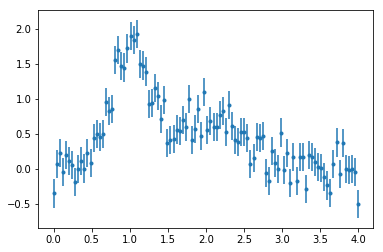

In [3]:
np.random.seed(100)
data_num = 100
num = 400
x0range = np.linspace(0.9,1.1,num)
x1range = np.linspace(1.8,2.2,num)
xdata = np.linspace(0,4,data_num)

X0, X1 = np.meshgrid(x0range, x1range)

y = dbl_Gauss(xdata,1,2,0.25,0.5)

x0 = X0.flatten()
x1 = X1.flatten()

yerr = 0.2  #The true Error bar
factor = 1.0 #Inflating or deflating the reported errorbar

yerr_arr = np.zeros(len(y)) + yerr*factor
y_noise = y + np.random.standard_normal(y.shape)*yerr

plt.errorbar(xdata,y_noise,yerr_arr,marker='.',linestyle="")
plt.show()

## Let's fit the data fixing X and Y

In [4]:
(param,cov) = curve_fit(dbl_Gauss,xdata,y_noise,sigma=yerr_arr,bounds=([.5,1.5,-np.inf,-np.inf],[1.5,3,np.inf,np.inf]))
print("X0: {:.4f} +/- {:.5f}".format(param[0],np.sqrt(cov[0,0])))
print("X1: {:.4f} +/- {:.5f}".format(param[1],np.sqrt(cov[1,1])))
print("X0_sig: {:.4f} +/- {:.5f}".format(param[2],np.sqrt(cov[2,2])))
print("X1_sig: {:.4f} +/- {:.5f}".format(param[3],np.sqrt(cov[3,3])))
print("Chi Squared: {:.3f}".format(get_chisq(xdata,y_noise,yerr_arr,param)))

X0: 0.9895 +/- 0.01277
X1: 1.9854 +/- 0.04399
X0_sig: 0.2399 +/- 0.01028
X1_sig: 0.5475 +/- 0.03546
Chi Squared: 91.027


## Do a grid search in $X_0$ and $Y_0$

In [5]:
#I assume equal space gridding
x0_width = (np.max(x0) - np.min(x0)) / num 
x1_width = (np.max(x1) - np.min(x1)) / num 
print(x0_width,x1_width)

0.0005 0.001


In [6]:
x0_fit = list()
x1_fit = list()
x0sig_fit = list()
x1sig_fit = list()
chisq = list()

time_ind = np.floor(len(x0)/10)
j = 1
beg_time = time.time()

for i in range(len(x0)):
    if i == (time_ind * j):
        print("Time Elapsed: {:.2f} min Percent Done: {:.0f}%".format((time.time()-beg_time)/60,j*10))
        j=j+1
    #Set boundaries to be centered on each x,y point with the 1/1000 width of that grid point
    (param,cov) = curve_fit(dbl_Gauss,xdata,y_noise,sigma=yerr_arr,
                                bounds=([x0[i]-(x0_width/1000),x1[i]-(x1_width/1000),-np.inf,-np.inf]
                                ,[x0[i]+(x0_width/1000),x1[i]+(x1_width/1000),np.inf,np.inf]))
    x0_fit.append(param[0])
    x1_fit.append(param[1])
    x0sig_fit.append(param[2])
    x1sig_fit.append(param[3])
    chisq.append(get_chisq(xdata,y_noise,yerr_arr,param))

print("Total Time: {:.2f} min".format((time.time()-beg_time)/60))

x0_fit_arr = np.array(x0_fit)   
x1_fit_arr = np.array(x1_fit) 
x0sig_fit_arr = np.array(x0sig_fit)         
x1sig_fit_arr = np.array(x1sig_fit)     
chisq_arr = np.array(chisq)

Time Elapsed: 1.81 min Percent Done: 10%
Time Elapsed: 3.74 min Percent Done: 20%
Time Elapsed: 5.83 min Percent Done: 30%
Time Elapsed: 7.94 min Percent Done: 40%
Time Elapsed: 10.07 min Percent Done: 50%
Time Elapsed: 12.39 min Percent Done: 60%
Time Elapsed: 14.59 min Percent Done: 70%
Time Elapsed: 16.77 min Percent Done: 80%
Time Elapsed: 19.09 min Percent Done: 90%
Total Time: 21.50 min


## Deriving Mean and Standard Deviation from probability
* Flat Prior
  * $\chi^2_i$ is the chi squared (not reduced $\chi^2$). I will subtract off the minimum $\chi^2 + 1$ to help 
     keep the exponentials in line. I do the plus 1 to avoid issues with log of 0.
  * Mean: $$<X> = \frac{\sum_i X_i \exp{\frac{-\chi^2_i}{2}}}{\sum_i \exp{\frac{-\chi^2_i}{2}}}$$
  * Variance: $$<(X-<X>)^2> = \frac{\sum_i (X_i-<X>)^2 \exp{\frac{-\chi^2_i}{2}}}{\sum_i \exp{\frac{-\chi^2_i}{2}}}$$
* Gaussian Prior centered on asteroseismic $\log g_0$ with $\sigma_{\log g}$.
$$\exp{\frac{-\chi^2_i}{2}} \rightarrow \exp{\frac{-\chi^2_i}{2}} \exp{\frac{-(\log g_i-\log g_0 )^2}{2(\sigma_{\log g}^2)}}$$
  * $\log g$ prior should be $2.564 \pm 0.01$

In [7]:
best_chisq = np.min(chisq_arr)
chisq_hold_arr = chisq_arr
chisq_arr = chisq_arr - best_chisq + 1

0.989223557639 1.98546265929


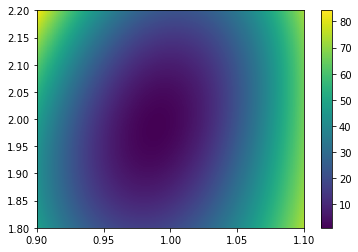

In [8]:
CHISQ_arr = chisq_arr.reshape(X0.shape)
plt.pcolormesh(X0,X1,CHISQ_arr)
ind = np.argmin(chisq_arr)
print(x0_fit[ind],x1_fit[ind])
plt.colorbar()
plt.show()

In [9]:
(param,cov) = curve_fit(dbl_Gauss,xdata,y_noise,sigma=yerr_arr,bounds=([.5,1.5,-np.inf,-np.inf],[1.5,3,np.inf,np.inf]))
print("X0: {:.4f} +/- {:.5f}".format(param[0],np.sqrt(cov[0,0])))
print("X1: {:.4f} +/- {:.5f}".format(param[1],np.sqrt(cov[1,1])))
print("X0_sig: {:.4f} +/- {:.5f}".format(param[2],np.sqrt(cov[2,2])))
print("X1_sig: {:.4f} +/- {:.5f}".format(param[3],np.sqrt(cov[3,3])))
print("Chi Squared: {:.3f}".format(get_chisq(xdata,y_noise,yerr_arr,param)))

X0: 0.9895 +/- 0.01277
X1: 1.9854 +/- 0.04399
X0_sig: 0.2399 +/- 0.01028
X1_sig: 0.5475 +/- 0.03546
Chi Squared: 91.027


In [10]:
#No prior
x0_mean,x0_std = get_mean_std(x0_fit_arr,chisq_arr)
print("X0: {:.4f} +/- {:.6f}".format(x0_mean,x0_std))
x1_mean,x1_std = get_mean_std(x1_fit_arr,chisq_arr)
print("X1: {:.4f} +/- {:.6f}".format(x1_mean,x1_std))
x0sig_mean,x0sig_std = get_mean_std(x0sig_fit_arr,chisq_arr)
print("X0sig: {:.4f} +/- {:.6f}".format(x0sig_mean,x0sig_std))
x1sig_mean,x1sig_std = get_mean_std(x1sig_fit_arr,chisq_arr)
print("X1sig: {:.4f} +/- {:.6f}".format(x1sig_mean,x1sig_std))
print("Chi Squared: {:.3f}".format(get_chisq(xdata,y_noise,yerr_arr,[x0_mean,x1_mean,x0sig_mean,x1sig_mean])))

X0: 0.9895 +/- 0.013199
X1: 1.9847 +/- 0.045794
X0sig: 0.2406 +/- 0.000875
X1sig: 0.5501 +/- 0.004490
Chi Squared: 91.034


In [11]:
#Including Prior
prior_mean = 1.0
prior_std = 0.008
x0_mean_p,x0_std_p = get_mean_std_prior(x0_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std)
print("X0: {:.4f} +/- {:.6f}".format(x0_mean_p,x0_std_p))
x1_mean_p,x1_std_p = get_mean_std_prior(x1_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std)
print("X1: {:.4f} +/- {:.6f}".format(x1_mean_p,x1_std_p))
x0sig_mean_p,x0sig_std_p = get_mean_std_prior(x0sig_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std)
print("X0sig: {:.4f} +/- {:.6f}".format(x0sig_mean_p,x0sig_std_p))
x1sig_mean_p,x1sig_std_p = get_mean_std_prior(x1sig_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std)
print("X1sig: {:.4f} +/- {:.6f}".format(x1sig_mean_p,x1sig_std_p))
print("Chi Squared: {:.3f}".format(get_chisq(xdata,y_noise,yerr_arr,[x0_mean_p,x1_mean_p,x0sig_mean_p,x1sig_mean_p])))

X0: 0.9972 +/- 0.006832
X1: 1.9920 +/- 0.044703
X0sig: 0.2402 +/- 0.000652
X1sig: 0.5508 +/- 0.004780
Chi Squared: 91.377


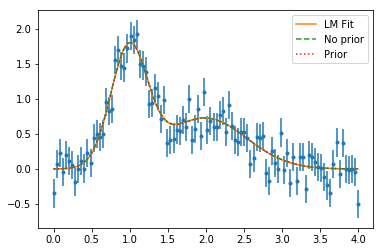

In [12]:
y_lm = dbl_Gauss(xdata,*param)
y_np = dbl_Gauss(xdata,x0_mean,x1_mean,x0sig_mean,x1sig_mean)
y_p = dbl_Gauss(xdata,x0_mean_p,x1_mean_p,x0sig_mean_p,x1sig_mean_p)
plt.errorbar(xdata,y_noise,yerr_arr,marker='.',linestyle="")
plt.plot(xdata,y_lm,label='LM Fit')
plt.plot(xdata,y_np,'--',label='No prior')
plt.plot(xdata,y_np,':',label='Prior')
plt.legend()
plt.show()

## Show Distributions
Let's give a prior on $X_0$ of $1.0 \pm 0.008$

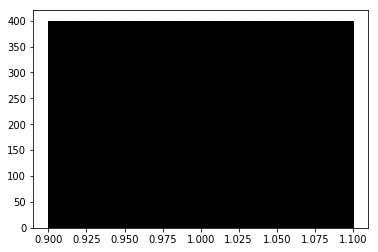

In [13]:
num = X0.shape[0]
plt.hist(x0_fit_arr,num,edgecolor='black')
plt.show()

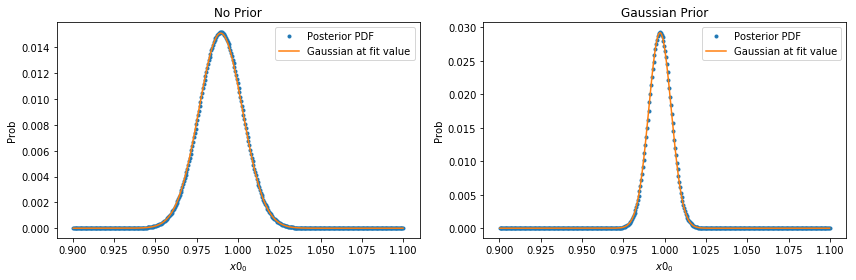

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
x0_prob,xcenter = get_posterior(x0_fit_arr,chisq_arr,num)
plt.plot(xcenter,x0_prob,'.',label='Posterior PDF')
plt.plot(xcenter,Gauss_prob(xcenter,x0_mean,x0_std)/np.sum(Gauss_prob(xcenter,x0_mean,x0_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$x0_0$")
plt.ylabel("Prob")
plt.legend()
plt.title("No Prior")
plt.subplot(1,2,2)
x0_prob,xcenter = get_posterior_prior(x0_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std,num)
plt.plot(xcenter,x0_prob,'.',label='Posterior PDF')
plt.plot(xcenter,Gauss_prob(xcenter,x0_mean_p,x0_std_p)/np.sum(Gauss_prob(xcenter,x0_mean_p,x0_std_p))
         ,label='Gaussian at fit value')
plt.xlabel(r"$x0_0$")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.tight_layout()

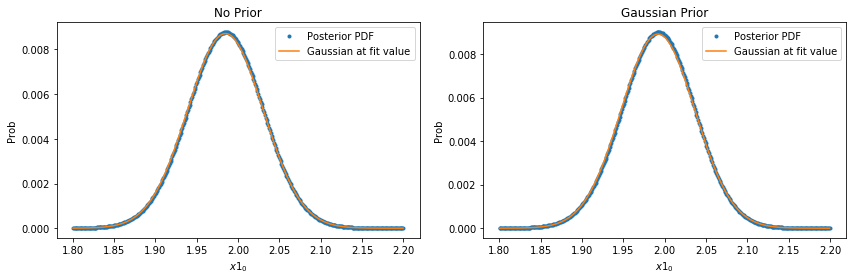

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
x1_prob,ycenter = get_posterior(x1_fit_arr,chisq_arr,num)
plt.plot(ycenter,x1_prob,'.',label='Posterior PDF')
plt.plot(ycenter,Gauss_prob(ycenter,x1_mean,x1_std)/np.sum(Gauss_prob(ycenter,x1_mean,x1_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$x1_0$")
plt.ylabel("Prob")
plt.legend()
plt.title("No Prior")
plt.subplot(1,2,2)
x1_prob,ycenter = get_posterior_prior(x1_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std,num)
plt.plot(ycenter,x1_prob,'.',label='Posterior PDF')
plt.plot(ycenter,Gauss_prob(ycenter,x1_mean_p,x1_std_p)/np.sum(Gauss_prob(ycenter,x1_mean_p,x1_std_p))
         ,label='Gaussian at fit value')
plt.xlabel(r"$x1_0$")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.tight_layout()

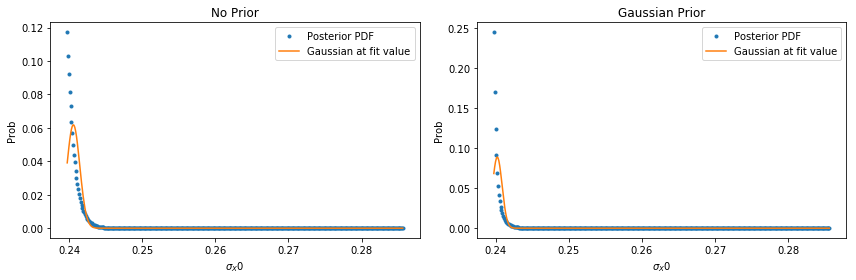

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
x0sig_prob,x0sigcenter = get_posterior(x0sig_fit_arr,chisq_arr,num)
plt.plot(x0sigcenter,x0sig_prob,'.',label='Posterior PDF')
plt.plot(x0sigcenter,Gauss_prob(x0sigcenter,x0sig_mean,x0sig_std)/np.sum(Gauss_prob(x0sigcenter,x0sig_mean,x0sig_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$\sigma_X0$")
plt.ylabel("Prob")
plt.legend()
plt.title("No Prior")
plt.subplot(1,2,2)
x0sig_prob,x0sigcenter = get_posterior_prior(x0sig_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std,num)
plt.plot(x0sigcenter,x0sig_prob,'.',label='Posterior PDF')
plt.plot(x0sigcenter,Gauss_prob(x0sigcenter,x0sig_mean_p,x0sig_std_p)/np.sum(Gauss_prob(x0sigcenter,x0sig_mean_p,x0sig_std_p))
         ,label='Gaussian at fit value')
plt.xlabel(r"$\sigma_X0$")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.tight_layout()

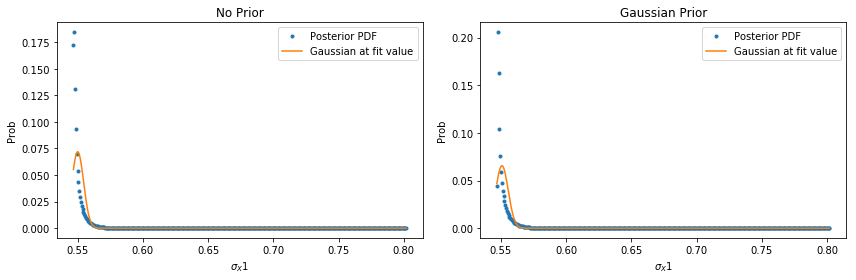

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
x1sig_prob,x1sigcenter = get_posterior(x1sig_fit_arr,chisq_arr,num)
plt.plot(x1sigcenter,x1sig_prob,'.',label='Posterior PDF')
plt.plot(x1sigcenter,Gauss_prob(x1sigcenter,x1sig_mean,x1sig_std)/np.sum(Gauss_prob(x1sigcenter,x1sig_mean,x1sig_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$\sigma_X1$")
plt.ylabel("Prob")
plt.legend()
plt.title("No Prior")
plt.subplot(1,2,2)
x1sig_prob,x1sigcenter = get_posterior_prior(x1sig_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std,num)
plt.plot(x1sigcenter,x1sig_prob,'.',label='Posterior PDF')
plt.plot(x1sigcenter,Gauss_prob(x1sigcenter,x1sig_mean_p,x1sig_std_p)/np.sum(Gauss_prob(x1sigcenter,x1sig_mean_p,x1sig_std_p))
         ,label='Gaussian at fit value')
plt.xlabel(r"$\sigma_X1$")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.tight_layout()

## Corner Plots

In [18]:
def posterior2vals(values,chisq,maxfreq=100):
    '''
    Converts an array of values and Chi-squared into a 1-d array length num with each value appearing at
    the rate given by the probability.
    
    Arguments:
        values: The data values of interest
        chisq: The chi-squared of each data value
        maxfreq: The number of times the most probable set of values appears (Default 100).
    Returns:
        A numpy array of values appearing at a frequency equal to thir probability.
    '''
    lh_prob = np.exp(-chisq/2) #Likliehood given Chi Squared statistic
    norm = np.sum(lh_prob)
    lh_prob = lh_prob/norm
   
    max_prob = np.max(lh_prob)
    
    factor = maxfreq/max_prob
    new_prob = lh_prob*factor
    
    new_values = list()
    for i in range(len(new_prob)):
        number = np.floor(new_prob[i])
        if number > 0:
            new_values.extend(np.repeat(values[i],number))
    new_values_arr = np.array(new_values)
    return(new_values_arr)

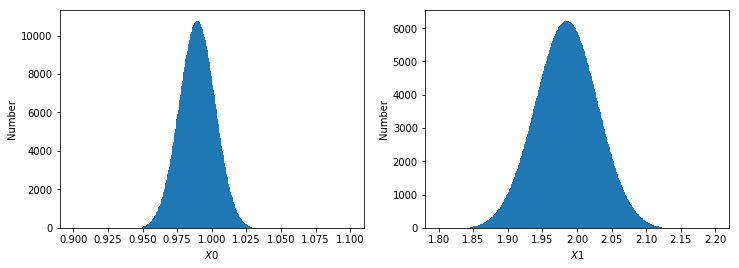

In [26]:
sample = 100
x0_trials = posterior2vals(x0_fit_arr,chisq_arr,sample)
x1_trials = posterior2vals(x1_fit_arr,chisq_arr,sample)
x0sig_trials = posterior2vals(x0sig_fit_arr,chisq_arr,sample)
x1sig_trials = posterior2vals(x1sig_fit_arr,chisq_arr,sample)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(x0_trials,num,range=(np.min(x0),np.max(x0)))
plt.xlabel(r"$X0$")
plt.ylabel("Number")
plt.subplot(1,2,2)
plt.hist(x1_trials,num,range=(np.min(x1),np.max(x1)))
plt.xlabel(r"$X1$")
plt.ylabel("Number")
plt.show()

In [27]:
data_comb = np.vstack([x0_trials,x1_trials,x0sig_trials,x1sig_trials])
data_comb = data_comb.T
print(data_comb.shape)

(696413, 4)


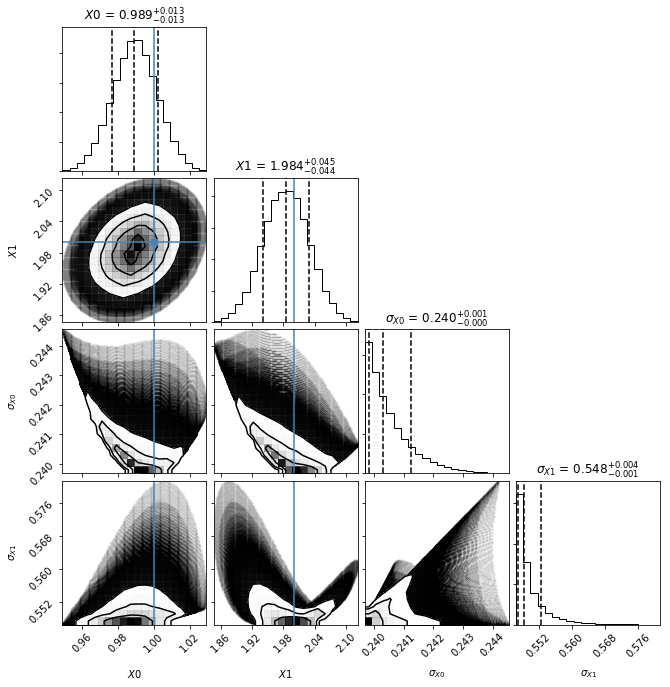

In [28]:
corner.corner(data_comb,labels=[r"$X0$", r"$X1$", r"$\sigma_{X0}$", r"$\sigma_{X1}$"],
                       quantiles=[0.16, 0.5, 0.84],truths=[1.0,2.0,0.25,0.5],
                       show_titles=True, title_fmt="0.3f",title_kwargs={"fontsize": 12})
plt.show()

## Corner Plots (now with Priors)

In [22]:
def posterior2vals_prior(values,chisq,prior_val,prior_mean,prior_std,maxfreq=100):
    '''
    Converts an array of values and chi-squared into a 1-d array length num with each value appearing at
    the rate given by the probability.
    
    Arguments:
        values: The data values of interest
        chisq: The chi-squared of each data value
        prior_val: The values array for the X_i to be used for the Gaussian prior
        prior_mean: The Gaussian Prior on the mean (X_0)
        prior_std: The Gaussian Prior Standard Deviation Sigma_X.
        maxfreq: The number of times the most probable set of values appears (Default 100).
    Returns:
        A numpy array of values appearing at a frequency equal to thir probability.
    '''
    lh_prob = np.exp(-chisq/2)*np.exp(-0.5*((prior_val-prior_mean)**2
                                        )/prior_std**2) #Likliehood and Gaussian Prior
    norm = np.sum(lh_prob)
    lh_prob = lh_prob/norm
   
    max_prob = np.max(lh_prob)
    
    factor = maxfreq/max_prob
    new_prob = lh_prob*factor
    
    new_values = list()
    for i in range(len(new_prob)):
        number = np.floor(new_prob[i])
        if number > 0:
            new_values.extend(np.repeat(values[i],number))
    new_values_arr = np.array(new_values)
    return(new_values_arr)

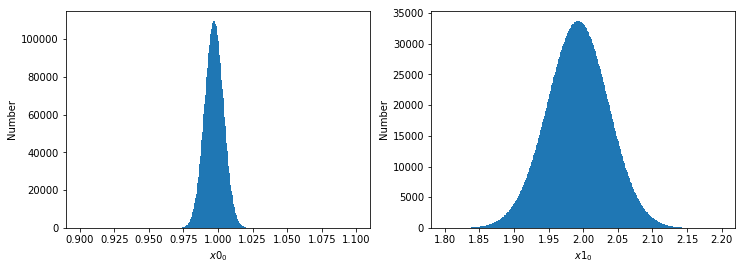

In [23]:
sample = 1000
x0_trials_p = posterior2vals_prior(x0_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std,sample)
x1_trials_p = posterior2vals_prior(x1_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std,sample)
x0sig_trials_p = posterior2vals_prior(x0sig_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std,sample)
x1sig_trials_p = posterior2vals_prior(x1sig_fit_arr,chisq_arr,x0_fit_arr,prior_mean,prior_std,sample)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(x0_trials_p,num,range=(np.min(x0),np.max(x0)))
plt.xlabel(r"$x0_0$")
plt.ylabel("Number")
plt.subplot(1,2,2)
plt.hist(x1_trials_p,num,range=(np.min(x1),np.max(x1)))
plt.xlabel(r"$x1_0$")
plt.ylabel("Number")
plt.show()

In [24]:
data_comb_p = np.vstack([x0_trials_p,x1_trials_p,x0sig_trials_p,x1sig_trials_p])
data_comb_p = data_comb_p.T
print(data_comb_p.shape)

(3732386, 4)


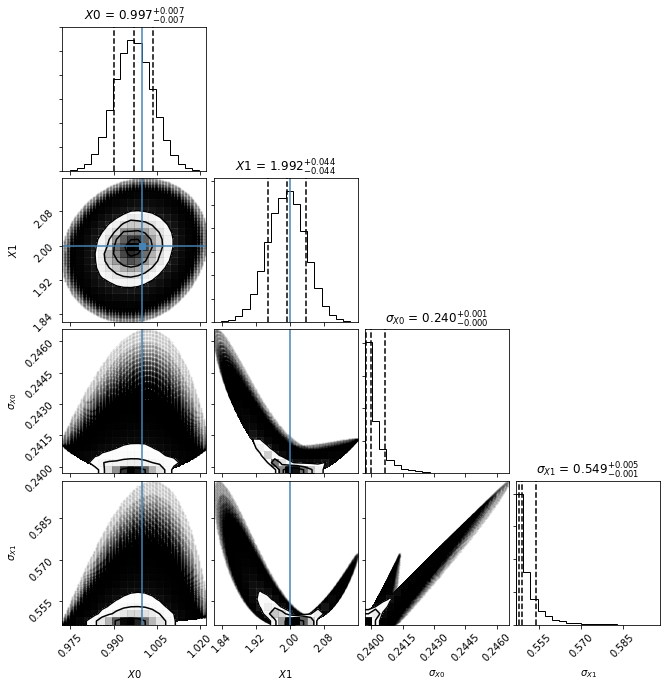

In [25]:
corner.corner(data_comb_p,labels=[r"$X0$", r"$X1$", r"$\sigma_{X0}$", r"$\sigma_{X1}$"],
                       quantiles=[0.16, 0.5, 0.84],truths=[1.0,2.0,0.5,0.75],
                       show_titles=True, title_fmt="0.3f",title_kwargs={"fontsize": 12})
plt.show()